# AI 기초 중간고사 대체 과제 - 202221880 유지용

In [1]:
# CNN 모델 구현을 위한 라이브러리 설치 및 import
%pip install torchvision
%pip install torchinfo

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Torchvision FashionMNIST Dataset load
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
# Dataset class naming list
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

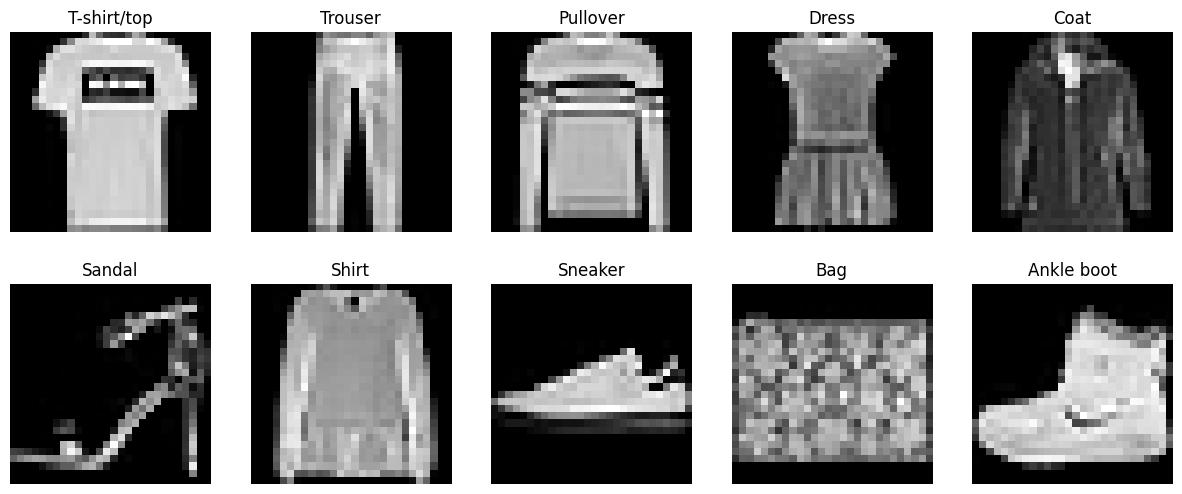

In [4]:
# 클래스 별 예시 이미지 가져오기
example_images = {}
for i in range(len(classes)):
    class_name = classes[i]
    for j in range(len(train_dataset)):
        if train_dataset[j][1] == i:
            example_images[class_name] = train_dataset[j][0]
            break

# 클래스 별 예시 이미지 plot을 사용하여 생성
def plot_example_images(images):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, (class_name, image) in enumerate(images.items()):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(image.squeeze(), cmap='gray')
        axes[row, col].set_title(class_name)
        axes[row, col].axis('off')
    plt.show()

# 이미지를 보여주는 함수 호출
plot_example_images(example_images)


In [5]:
# 데이터 전처리 및 DataLoader 생성, batch_size = 128로 지정
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [6]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명
%pip install torchsummary 
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
# 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [7]:
def train(model, train_loader, test_loader, epochs=5):
    # 손실 함수 및 최적화기 정의
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    try:
        for epoch in range(epochs):
            train_loss, train_correct, train_total = 0, 0, 0
            for data, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(data)

                if outputs is None:
                    print("Warning: Model output is None.")
                    continue
                loss = criterion(outputs, labels)
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, prediected = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (prediected == labels).sum().item()
                
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            # 테스트 데이터셋에 대한 손실 계산
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, labels in test_loader:
                    outputs = model(data)
                    if outputs is None:
                        print("Warning: Model output is None during evaluation.")
                        continue

                    loss = criterion(outputs, labels)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue

                    test_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)

            print(f'Epoch [{epoch+1}/{epochs}], '
                f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
        
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

In [8]:
def analyze_misclassified(model, test_loader, classes):
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:  # 잘못 분류된 이미지인 경우
                    misclassified_images.append(images[i])
                    true_labels.append(classes[labels[i]])
                    predicted_labels.append(classes[predicted[i]])

    num_misclassified = len(misclassified_images)
    print(f"Total misclassified images: {num_misclassified}")

    # 잘못 분류된 이미지 플롯
    num_rows = 1
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3))
    for i, ax in enumerate(axes.flat):
        if i < num_misclassified:
            ax.imshow(misclassified_images[i].squeeze(), cmap='gray')
            ax.set_title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Epoch [1/20], Train Loss: 0.0037, Train Acc: 83.56%, Test Loss: 0.0032, Test Acc: 85.73%
Epoch [2/20], Train Loss: 0.0026, Train Acc: 88.07%, Test Loss: 0.0030, Test Acc: 86.90%
Epoch [3/20], Train Loss: 0.0024, Train Acc: 89.22%, Test Loss: 0.0029, Test Acc: 87.31%
Epoch [4/20], Train Loss: 0.0022, Train Acc: 90.07%, Test Loss: 0.0029, Test Acc: 87.56%
Epoch [5/20], Train Loss: 0.0021, Train Acc: 90.70%, Test Loss: 0.0028, Test Acc: 87.83%
Epoch [6/20], Train Loss: 0.0019, Train Acc: 91.22%, Test Loss: 0.0028, Test Acc: 87.94%
Epoch [7/20], Train Loss: 0.0018, Train Acc: 91.65%, Test Loss: 0.0028, Test Acc: 88.15%
Epoch [8/20], Train Loss: 0.0018, Train Acc: 92.10%, Test Loss: 0.0028, Test Acc: 88.20%
Epoch [9/20], Train Loss: 0.0017, Train Acc: 92.51%, Test Loss: 0.0028, Test Acc: 88.34%
Epoch [10/20], Train Loss: 0.0016, Train Acc: 92.76%, Test Loss: 0.0028, Test Acc: 88.42%
Epoch [11/20], Train Loss: 0.0016, Train Acc: 93.08%, Test Loss: 0.0028, Test Acc: 88.42%
Epoch [12/20], Trai

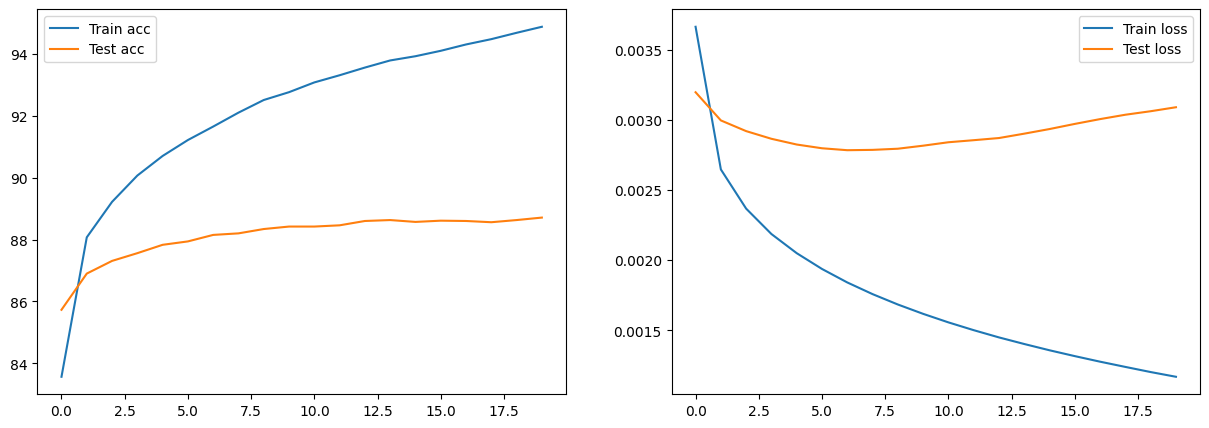

In [9]:
hist = train(net, train_loader, test_loader, epochs=20)
if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면 train, test data의 정확도와 손실값 시각화
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Train acc')
    plt.plot(hist['test_acc'], label='Test acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Train loss')
    plt.plot(hist['test_loss'], label='Test loss')
    plt.legend()
    plt.show()

Total misclassified images: 1129


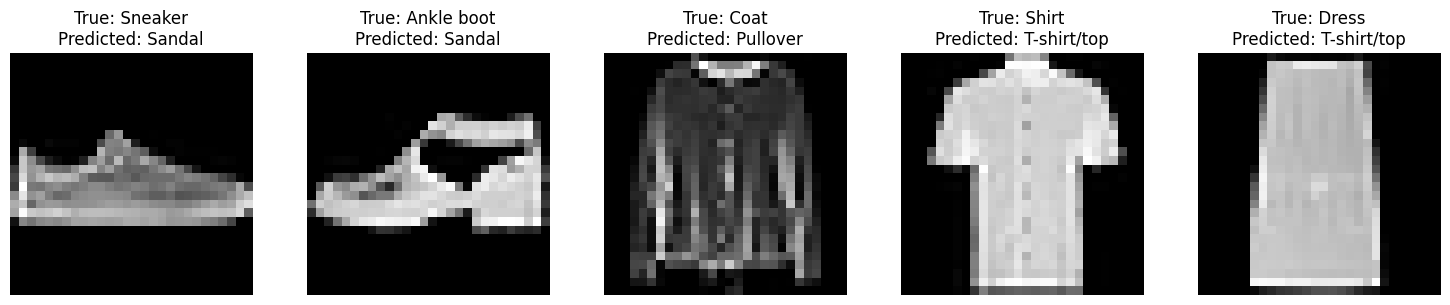

In [10]:
# 훈련시킨 모델에서, 해당 모델을 이용하여 analyze_misclassified 함수를 호출하여 총 잘못 분류된 이미지 갯수, 잘못 판단된 이미지 예시 5개 출력
analyze_misclassified(net, test_loader, classes)

In [11]:
from collections import Counter

def plot_most_misclassified_class(model, test_loader, classes):
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:  # 잘못 분류된 이미지인 경우
                    misclassified_images.append(images[i])
                    true_labels.append(classes[labels[i]])
                    predicted_labels.append(classes[predicted[i]])

    # 가장 많이 발생한 잘못 분류된 클래스 찾기
    misclassified_counter = Counter(true_labels)
    most_misclassified_class = misclassified_counter.most_common(1)[0][0]

    # 클래스별 잘못 분류된 이미지 수 계산
    misclassified_counts = [misclassified_counter[class_name] for class_name in classes]

    # 그래프로 표시
    plt.figure(figsize=(10, 6))
    plt.bar(classes, misclassified_counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Misclassified Count')
    plt.title('Misclassified Images by Class')
    plt.xticks(rotation=45, ha='right')
    plt.show()

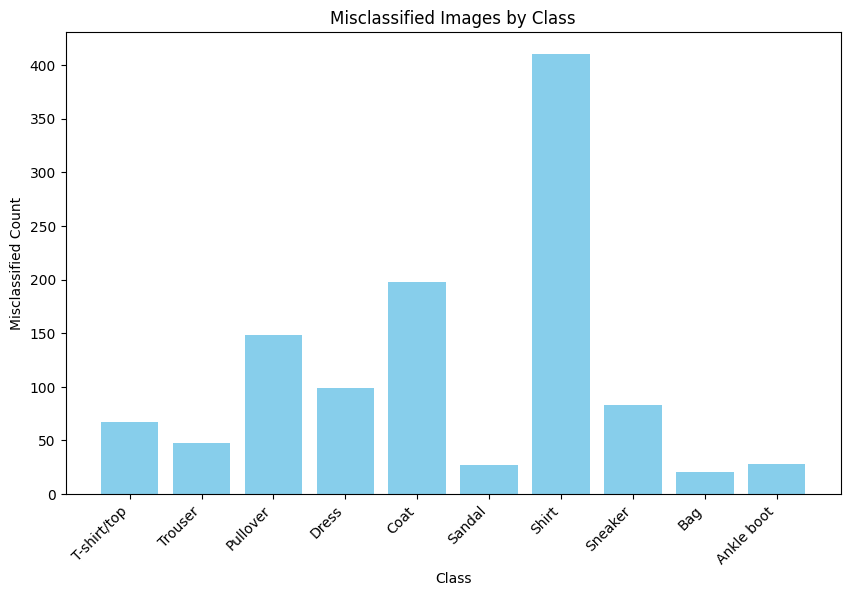

In [12]:
# 클래스 별 분류가 잘못된 비율 plot 차트
plot_most_misclassified_class(net, test_loader, classes)

### 최대 epoch를 20번까지 돌려보았으며, 88.71% 까지의 정확도가 나왔습니다. 손실 or 잘못 분류된 데이터는 총 1129개의 데이터로 집계되었고, 그 중 가장 잘못 학습된 클래스는 Shirt class로 나타났습니다.